<a href="https://colab.research.google.com/github/maxmatical/ml-cheatsheet/blob/master/Pytorch_Lightning_BERT_Huggingface_w_SAM_%2B_EMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inspirations
https://curiousily.com/posts/multi-label-text-classification-with-bert-and-pytorch-lightning/

https://github.com/mgrankin/over9000/blob/master/train.py


https://medium.com/pytorch/getting-started-with-ray-lightning-easy-multi-node-pytorch-lightning-training-e639031aff8b


In [1]:
!nvidia-smi

Sat Jan  1 21:42:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    58W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%%capture
!pip install transformers
!pip install pytorch_lightning
!pip install torchmetrics
!pip install torch-ema

In [42]:
from typing import Optional
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import OneCycleLR # , ReduceLROnPlateau
from torch.optim import AdamW

from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
  
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor, StochasticWeightAveraging
from pytorch_lightning.loggers import TensorBoardLogger
import torchmetrics
from torchmetrics.functional import accuracy, f1, auroc

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

from torch_ema import ExponentialMovingAverage

In [4]:
# pretrained model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")
model = AutoModel.from_pretrained("distilroberta-base")

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Data

In [5]:
!gdown --id 1VuQ-U7TtggShMeuRSA_hzC8qGDl2LRkr

Downloading...
From: https://drive.google.com/uc?id=1VuQ-U7TtggShMeuRSA_hzC8qGDl2LRkr
To: /content/toxic_comments.csv
100% 68.8M/68.8M [00:00<00:00, 132MB/s] 


In [6]:
df = pd.read_csv("toxic_comments.csv")

df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
train_df, val_df = train_test_split(df, test_size=0.15)

In [8]:
# subsample clean comments
LABEL_COLUMNS = df.columns.tolist()[2:]

train_toxic = train_df[train_df[LABEL_COLUMNS].sum(axis=1) > 0]
train_clean = train_df[train_df[LABEL_COLUMNS].sum(axis=1) == 0]

train_df = pd.concat([
  train_toxic,
  train_clean.sample(15_000)
])

train_df.shape, val_df.shape

((28754, 8), (23936, 8))

In [9]:
# take only a subsample of each train_df and val_df for faster iterations
train_df = train_df.sample(1000)
val_df = val_df.sample(1000)

train_df.shape, val_df.shape

((1000, 8), (1000, 8))

## Creating Dataset and Lightning Data Module

In [10]:
# set batch size and max seq_len
bs = 12
seq_len = 256

In [11]:
class ToxicCommentsDataset(Dataset):

  def __init__(
    self,
    data: pd.DataFrame,
    tokenizer: AutoTokenizer,
    max_token_len: int = 128

  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]
    comment_text = data_row.comment_text
    labels = data_row[LABEL_COLUMNS]

    encoding = self.tokenizer.encode_plus(
      comment_text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',

    )

    return dict(
      # comment_text=comment_text, # don't put text here
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels = torch.IntTensor(labels)
    #   labels=torch.FloatTensor(labels)
    )

In [12]:
# test
train_dataset = ToxicCommentsDataset(
  train_df,
  tokenizer,
  max_token_len=seq_len
)

sample_item = train_dataset[0]
sample_item.keys()

dict_keys(['input_ids', 'attention_mask', 'labels'])

In [13]:
print(sample_item["input_ids"], sample_item["labels"])
print(sample_item["input_ids"].shape)

tensor([    0,  9178,   171,   481,  3156,    33,    47, 32840,   116,    99,
           16,   110,    92,  3018,   766,    35,   741, 14141, 14141,  1988,
         1120,   116,     2,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1, 

In [86]:
class ToxicCommentsDataModule(pl.LightningDataModule):
  def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=512):
    super().__init__()
    self.train_df, self.test_df = train_df, test_df
    self.tokenizer = tokenizer
    self.batch_size = batch_size
    self.max_token_len = max_token_len

  def setup(self, stage=None):
    self.train_dataset = ToxicCommentsDataset(
        self.train_df,
        self.tokenizer,
        self.max_token_len
    )

    self.test_dataset = ToxicCommentsDataset(
        self.test_df,
        self.tokenizer,
        self.max_token_len
    )

  def train_dataloader(self):
    return DataLoader(
        self.train_dataset,
        batch_size = self.batch_size,
        shuffle = True,
        num_workers=1
    )

  def val_dataloader(self):
    return DataLoader(
        self.test_dataset,
        batch_size = self.batch_size,
        shuffle = False,
        num_workers=1
    )

  def test_dataloader(self):
    return DataLoader(
        self.test_dataset,
        batch_size = self.batch_size,
        shuffle = False,
        num_workers=1
    )

In [87]:
data_module = ToxicCommentsDataModule(
    train_df,
    val_df,
    tokenizer,
    batch_size = bs,
    max_token_len = seq_len
)


In [89]:
data_module.setup() # call this before getting len of dataloader
len(data_module.train_dataloader())

84

# SAM

In [18]:
class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, adaptive=False, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, adaptive=adaptive, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None: continue
                self.state[p]["old_p"] = p.data.clone()
                e_w = (torch.pow(p, 2) if group["adaptive"] else 1.0) * p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.data = self.state[p]["old_p"]  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)  # the closure should do a full forward-backward pass

        self.first_step(zero_grad=True)
        closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
                    torch.stack([
                        ((torch.abs(p) if group["adaptive"] else 1.0) * p.grad).norm(p=2).to(shared_device)
                        for group in self.param_groups for p in group["params"]
                        if p.grad is not None
                    ]),
                    p=2
               )
        return norm

    def load_state_dict(self, state_dict):
        super().load_state_dict(state_dict)
        self.base_optimizer.param_groups = self.param_groups

# Model

In [19]:
sample_batch = next(iter(DataLoader(train_dataset, batch_size=bs, num_workers=1)))
sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape

(torch.Size([12, 256]), torch.Size([12, 256]))

In [20]:
# test lr schedule with https://www.kaggle.com/isbhargav/guide-to-pytorch-learning-rate-scheduling
# test wtih flat cos lr

In [21]:
class BertModel(nn.Module):
  def __init__(self, n_classes: int):
    super().__init__()
    self.model = model
    self.classifier = nn.Linear(self.model.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask): 
    out = self.model(input_ids, attention_mask=attention_mask)
    out = self.classifier(out.pooler_output)
    return out

In [22]:
bert_model = BertModel(len(LABEL_COLUMNS)).to("cuda")



In [23]:
# bert_model(sample_batch["input_ids"], sample_batch["attention_mask"]).shape  # should be bs x 6

# model saver to save only pytorch model

In [43]:
class ModelSaver:
  def __init__(self, save_path: str, mode: str = "max"):
    """
    class used for saving models during training
    """
    self.save_path = save_path
    self.mode = mode
    assert self.mode in ["min", "max"], f"mode {mode} not found"
    # self.best_value = torch.tensor(float("inf")) if mode == "min" else torch.tensor(float("-inf"))
    self.best_value = float("inf") if mode == "min" else float("-inf")

  def save_model(self, epoch: int, model: nn.Module, current_value: float):
    """
    compares current_value with self.best_value
    if current_value is better then
    1. save model weights to self.save_path
    2. update self.best_value with current_value
    """
    if (
      (self.mode == "min" and current_value <= self.best_value)
      or (self.mode == "max" and current_value >= self.best_value)
    ):
      torch.save(model.state_dict(), self.save_path)
      print(f"better model found at epoch {epoch} with value {current_value}")
      print(f"model weights saved to '{self.save_path}', to load model weights, create new model and use new_model.load_state_dict(torch.load('{self.save_path}'))")
      self.best_value = current_value

# PL Module

In [106]:
class ToxicCommentClassifier(pl.LightningModule):
  def __init__(
      self, 
      pytorch_model: nn.Module, 
      total_steps: int, 
      lr: float = 2e-5, 
      rho: float = 0.05,
      asam: bool = False,
      fit_func: str = "one_cycle", 
      is_ddp: bool = False,
      use_ema: bool = False,
      accumulate_grad_batches: int = 1,
      model_saver: Optional[ModelSaver] = None
               
  ):
    super().__init__()
    self.lr = lr
    self.rho = rho  # neighborhood size for SAM
    self.asam = asam  # whether to use adaptive sam
    self.total_steps = total_steps # for lr schedule
    self.fit_func = fit_func
    self.is_ddp = is_ddp 
    self.use_ema = use_ema
    self.ema = None
    self.grad_acc_batches = accumulate_grad_batches
    
    self.pytorch_model = pytorch_model
    self.criterion = nn.BCEWithLogitsLoss() # bce for multi-label

    if self.use_ema:
      # self.pytorch_model should be moved to device
      self.ema = ExponentialMovingAverage(self.pytorch_model.parameters(), decay=0.995)

    # metrics 
    self.f1 = torchmetrics.F1()

    # manually define opt step
    self.automatic_optimization = False

    # track lr schedule
    self.lr_schedule = []

    # keep track of inputs for sam 2nd update with gradient accumulation
    self.input_list, self.attn_mask_list, self.labels_list = [], [], []

    # model saving logic
    self.model_saver = model_saver

  def on_fit_start(self):
    """
    at the beginning of training
    - set up scaler for mixed precision (used for SAM manual updates)
    """
    # track scaler for manual optimization
    self.scaler = None
    if hasattr(self.trainer.precision_plugin, "scaler"):
      self.scaler = self.trainer.precision_plugin.scaler
    print(self.scaler)

    print(self.trainer.model)

  def forward(self, input_ids, attention_mask):
    """
    forward step for lightning module
    """
    out = self.pytorch_model(input_ids, attention_mask=attention_mask)
    return out

  def training_step(self, batch, batch_idx):
    """
    training step
    since using manual optimization: only precision and accelerator logic is handled by Lightning

    Must manually specify everything else, such as:
    - manual optimization logic ie 
      - opt = self.optimizers()
      - opt.zero_grad()
      - self.manual_backward(loss)
      - and opt.step()
    - learning rate scheduler step
    - gradient accumulation logic
    - gradient clipping
    - etc
    """
    # batch comes from dataset
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]

    # save input and output for 2nd step
    self.input_list.append(input_ids)
    self.attn_mask_list.append(attention_mask)
    self.labels_list.append(labels)


    out = self(input_ids, attention_mask)
    loss = self.criterion(out, labels.to(dtype=torch.float32)) # cast to float because labels is in Int
    # scale the loss by gradient accumulation batches
    loss = loss / self.grad_acc_batches

    # track f1, use sigmoid first
    f1 = self.f1(torch.sigmoid(out), labels)

    """
    IMPORTANT NOTE:
    need to manually handle scaling with optimizer
    need to call opt.optimizer.first_step_step(zero_grad=True)
    and manaually scale/unscale gradients and call scaler.update()
    """

    # loss backward
    if self.is_ddp:
      # maybe should be `with self.pytorch_model.no_sync()`?
      # (test with both on ddp)
      with self.trainer.model.no_sync():
        self.manual_backward(loss)
    else:
      self.manual_backward(loss)

    # optimizer step every grad_acc_batches steps
    if (batch_idx + 1) % self.grad_acc_batches == 0:
      """
      must use manual optimization with scaling logic eg
      https://github.com/PyTorchLightning/pytorch-lightning/discussions/11290

      ```
      optimizer = self.optimizers().optimizer # access pytorch optimizer from lightningoptimizer
      scaler = self.trainer.precision_plugin.scalar
      if scaler:
        scaler.unscale_(optimizer)
        optimizer.first_step(zero_grad=True)
        scaler.update()

      else:
        optimizer.first_step(zero_grad=True)

      # 2nd pass
      ...

      ```
      """
      # acecss the optimizer
      # since using sam, want to use the base pytorch optimizer
      # get the pytorch optimizer from lightning optimizer
      optimizer = self.optimizers().optimizer 
      self.lr_schedule.append(optimizer.param_groups[0]["lr"]) # check that lrs are the same (is true)

      if self.scaler:
        self.scaler.unscale_(optimizer)
        optimizer.first_step(zero_grad=True)
        self.scaler.update()
      else:
        optimizer.first_step(zero_grad=True)

      # 2nd forward pass with saved input_list and labels_list
      # to get the accumulated gradients again
      for (input_ids, attention_mask, labels) in list(zip(self.input_list, self.attn_mask_list, self.labels_list)):
        out_2 = self(input_ids, attention_mask)
        loss_2 = self.criterion(out_2, labels.to(dtype=torch.float32))
        loss_2 = loss_2 / self.grad_acc_batches
        self.manual_backward(loss_2)
        # 2nd optimizer step
        if self.scaler:
          self.scaler.unscale_(optimizer)
          optimizer.second_step(zero_grad=True)
          self.scaler.update()
        else:
          optimizer.second_step(zero_grad=True)

      # clear saved lists
      self.input_list, self.attn_mask_list, self.labels_list = [], [], []

      # update ema (after every optimizer step)
      if self.use_ema:
        self.ema.update() # note: this might be self.ema.update(self.trainer.model.parameters()) or maybe self.parameters()?
        # self.ema.update(self.trainer.model.parameters())

      # lr schedule (every optimizer step)
      lr_sch = self.lr_schedulers()
      lr_sch.step()

    # log loss and metrics each k steps and each epoch
    loss = loss * self.grad_acc_batches  # scale loss back wrt gradient accumulation
    log_values = {"loss": loss, "train_f1": f1}
    self.log_dict(log_values, sync_dist=True, prog_bar=True, on_step=True, on_epoch=False)
    return {"loss": loss, "train_f1": f1}

  def validation_step(self, batch, batch_idx):
    """
    validation step
    get validation loss and accuracy metrics
    """
    # batch comes from dataset
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]

    if self.use_ema:
      with self.ema.average_parameters():
        out = self(input_ids, attention_mask)
    else:
      out = self(input_ids, attention_mask)

    # compute loss + metrics
    loss = self.criterion(out, labels.to(dtype=torch.float32)) # cast to float because labels is in Int
    f1 = self.f1(out, labels)
    # log loss and metrics each k steps and each epoch
    log_values = {"val_loss": loss, "val_f1": f1}
    self.log_dict(log_values, sync_dist=True, prog_bar=True, on_step=True, on_epoch=False)
    return {"val_loss": loss, "val_f1": f1}

  def training_epoch_end(self, outputs):
    """
    after every training epoch, log train metrics

    note: this might not be needed if logging is done for each step and epoch
    """
    # log validation loss and metrics
    avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
    avg_f1 = torch.stack([x["train_f1"] for x in outputs]).mean()

    self.log("avg_train_loss", avg_loss, sync_dist=True, prog_bar=True)
    self.log("avg_train_f1", avg_f1, sync_dist=True, prog_bar=True)

  def validation_epoch_end(self, outputs):
    """
    after every training epoch, log val metrics
    also save pytorch model weights to be loaded and decoupled
    """
    # log validation loss and metrics
    avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
    avg_f1 = torch.stack([x["val_f1"] for x in outputs]).mean()
    self.log("avg_val_loss", avg_loss, sync_dist=True, prog_bar=True)
    self.log("avg_val_f1", avg_f1, sync_dist=True, prog_bar=True)

    if self.model_saver:
      if self.use_ema:
        with self.ema.average_parameters():
          self.model_saver.save_model(self.current_epoch, self.pytorch_model, avg_f1)
      else:
        self.model_saver.save_model(self.current_epoch, self.pytorch_model, avg_f1)

  def configure_optimizers(self):
    # TODO: 
    # 1. automatically find steps for onecycleLR
    # 2. add flat cos
    # 3. make lr scheduler configurable(one_cycle vs flat_cos)

    # trying SAM
    base_optimizer = AdamW
    optimizer = SAM(
        self.pytorch_model.parameters(), 
        base_optimizer=base_optimizer, 
        lr=self.lr, 
        betas=(0.9, 0.99),
        rho=self.rho,
        adaptive=self.asam
    )
    # lr schedule with sam (seems to work fine with 2 step?)
    scheduler = OneCycleLR(
      optimizer=optimizer,
      max_lr=self.lr,
      pct_start=0.3,
      total_steps=self.total_steps
    )
    
    return [optimizer], [scheduler]

  def on_save_checkpoint(self, checkpoint):
    """
    saving model weights, configurable with EMA
    """
    if self.ema:
      with self.ema.average_parameters():
        checkpoint['state_dict'] = self.state_dict()
    else:
      checkpoint['state_dict'] = self.state_dict()

In [107]:
# training epoch related hyperparams
steps_per_epoch = len(data_module.train_dataloader())
n_epochs = 1
accumulate_grad_batches = 4
n_gpus = 1


total_steps = int(steps_per_epoch * n_epochs / n_gpus / accumulate_grad_batches)
print(f"total_steps: {total_steps}")


# creating model saver
model_saver = ModelSaver(save_path="test.pth", mode="max")

total_steps: 21


Note: if using multiple gpus, total steps calculation is something like
```
steps_per_epoch = len(data_module.train_dataloader())

# for gpu or tpu cores
num_devices = 4
if tpu_cores:
    num_devices = max(num_devices, tpu_cores)

accumulate_grad_batches = 1 # for no gradient accumulation

effective_accum = accumulate_grad_batches * num_devices
total_steps (steps_per_epoch // effective_accum) * n_epochs

```

In [108]:
del bert_model
bert_model = BertModel(len(LABEL_COLUMNS)).to("cuda")


In [109]:
toxic_comment_model = ToxicCommentClassifier(
  bert_model, 
  total_steps = total_steps, 
  use_ema=True, 
  lr=0.1, 
  accumulate_grad_batches=accumulate_grad_batches,
  model_saver=model_saver

)

In [110]:
sam = toxic_comment_model.configure_optimizers()[0][0]
sam.param_groups[0]["lr"]

0.0040000000000000036

# Trainer

defining the trainer and running `trainer.fit` 

In [111]:
# callbacks
lr_monitor_cb = LearningRateMonitor(logging_interval='step')

checkpoint_callback = ModelCheckpoint(
  dirpath="checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="avg_val_f1",
  mode="max"
)

early_stopping_callback = EarlyStopping(monitor='avg_val_loss', patience=6)

logger = TensorBoardLogger("lightning_logs", name="toxic-comments")

# standard callback, checkpoint and early stopping
# callbacks = [lr_monitor_cb, checkpoint_callback, early_stopping_callback]

callbacks = [early_stopping_callback]

In [112]:
trainer = pl.Trainer(
    logger=logger,
    callbacks = callbacks,
    precision=32,
    max_epochs = n_epochs,
    accelerator="gpu",
    devices=n_gpus,
    num_sanity_val_steps=0
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [113]:
# optional: currently not working?
# lr_finder = trainer.tuner.lr_find(model=toxic_comment_model, datamodule=data_module)

In [114]:
trainer.fit(toxic_comment_model, data_module)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:686: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [100]:
trainer.logged_metrics

{'avg_train_f1': 0.16689248383045197,
 'avg_train_loss': 1.9315109252929688,
 'avg_val_f1': 0.0,
 'avg_val_loss': 0.3577773869037628,
 'loss': tensor(1.7774),
 'train_f1': tensor(0.),
 'val_f1': 0.0,
 'val_loss': 0.07361804693937302}

[0.0040000000000000036, 0.012188527098390314, 0.03396027605851658, 0.06188697369957272, 0.08644034833812791, 0.09924306774148466, 0.09944154354509119, 0.09673623556045154, 0.09190443762697105, 0.08516599658482699, 0.07682751154913771, 0.0672683836480545, 0.056923553268744854, 0.046263710266697504, 0.035773877573965704, 0.02593134265232537, 0.01718394091038552, 0.009929679189326548, 0.004498626448808909, 0.0011378956269720922, 4e-07]
21 21


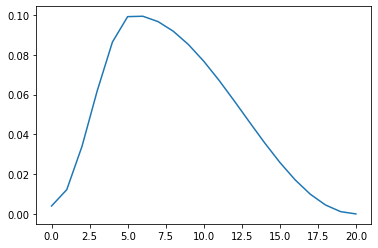

In [101]:
# validate lr scheduler is working correctly
print(toxic_comment_model.lr_schedule)
print(len(toxic_comment_model.lr_schedule), total_steps)
from matplotlib import pyplot as plt

plt.plot(toxic_comment_model.lr_schedule)

In [102]:
# %reload_ext tensorboard
# %tensorboard --logdir lightning_logs/


### VERIFY THAT EMA MODEL SAVING WORKS AS INTENDED




In [103]:
# original weights before ema
toxic_comment_model.pytorch_model.classifier.weight



Parameter containing:
tensor([[ 0.0316, -0.0078,  0.0104,  ..., -0.0257,  0.0246, -0.0016],
        [ 0.0284,  0.0080, -0.0036,  ..., -0.0382, -0.0260, -0.0281],
        [ 0.0157,  0.0159,  0.0282,  ..., -0.0107, -0.0175,  0.0080],
        [ 0.0080, -0.0246,  0.0032,  ..., -0.0113,  0.0063, -0.0386],
        [-0.0117,  0.0171, -0.0172,  ..., -0.0439,  0.0406,  0.0099],
        [-0.0527, -0.0562,  0.0380,  ..., -0.0491, -0.0010, -0.0339]],
       requires_grad=True)

In [104]:
bert_model2 = BertModel(len(LABEL_COLUMNS))
toxic_comment_model.ema.copy_to(bert_model2.parameters())
print("after ema weights")
print(bert_model2.classifier.weight)

after ema weights
Parameter containing:
tensor([[ 0.0316, -0.0079,  0.0104,  ..., -0.0257,  0.0246, -0.0016],
        [ 0.0257,  0.0053, -0.0009,  ..., -0.0409, -0.0233, -0.0308],
        [ 0.0122,  0.0125,  0.0317,  ..., -0.0142, -0.0140,  0.0045],
        [ 0.0056, -0.0270,  0.0056,  ..., -0.0137,  0.0087, -0.0411],
        [-0.0115,  0.0173, -0.0174,  ..., -0.0437,  0.0404,  0.0100],
        [-0.0605, -0.0640,  0.0457,  ..., -0.0569,  0.0067, -0.0417]],
       requires_grad=True)


In [105]:
# verify model loading
bert_model3 = BertModel(len(LABEL_COLUMNS))
bert_model3.load_state_dict(torch.load("test.pth"))
print(bert_model3.classifier.weight)

Parameter containing:
tensor([[ 0.0316, -0.0079,  0.0104,  ..., -0.0257,  0.0246, -0.0016],
        [ 0.0257,  0.0053, -0.0009,  ..., -0.0409, -0.0233, -0.0308],
        [ 0.0122,  0.0125,  0.0317,  ..., -0.0142, -0.0140,  0.0045],
        [ 0.0056, -0.0270,  0.0056,  ..., -0.0137,  0.0087, -0.0411],
        [-0.0115,  0.0173, -0.0174,  ..., -0.0437,  0.0404,  0.0100],
        [-0.0605, -0.0640,  0.0457,  ..., -0.0569,  0.0067, -0.0417]],
       requires_grad=True)


conclusion: model saver with EMA works as intended and can be loaded directly to pytorch module